# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [2]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [3]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

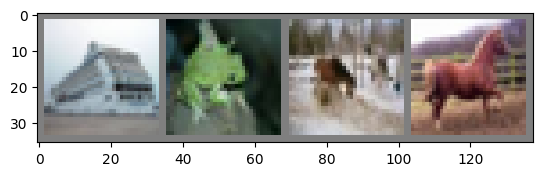

ship frog horse horse


In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [5]:
from torch.nn.modules.activation import ReLU

n_classes = 10


class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
        )

        self.conv = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1)

        self.block2 = nn.Sequential(nn.ReLU(), nn.AvgPool2d(kernel_size=8))

        self.linear = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        flatten_input = self.block2(self.block1(x) + self.conv(x))

        flattened = torch.flatten(flatten_input, start_dim=1)

        out = self.linear(flattened)

        return out

In [6]:
net = BasicBlockNet()
net

BasicBlockNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (block2): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [7]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [9]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [10]:
from torch.nn.functional import cross_entropy


def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        predictions = model(data)
        loss = cross_entropy(predictions, target)

        loss_log.append(loss.item())

        predicted_classes = torch.argmax(predictions, 1)
        acc = torch.sum(predicted_classes == target) / target.size(dim=0)

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        predictions = model(data)
        loss = cross_entropy(predictions, target)

        loss_log.append(loss.item())

        loss.backward()
        optimizer.step()

        predicted_classes = torch.argmax(predictions, 1)
        acc = torch.sum(predicted_classes == target) / target.size(dim=0)
        acc_log.append(acc.item())

    return loss_log, acc_log


def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [11]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.464754533070315, train acc: 0.47817233613465776
 val loss: 1.2005993642705552, val acc: 0.5722960994598714

Epoch 1
 train loss: 1.1631658207999722, train acc: 0.5935990141340322
 val loss: 1.155336849993848, val acc: 0.5975398936170213

Epoch 2
 train loss: 1.0448934043565223, train acc: 0.6371523244289419
 val loss: 1.0862762441026403, val acc: 0.625

Epoch 3
 train loss: 0.9875145814972343, train acc: 0.6576864064502542
 val loss: 1.0678648535241473, val acc: 0.6341976952045522

Epoch 4
 train loss: 0.9548641253650951, train acc: 0.6703692218067441
 val loss: 0.976625239341817, val acc: 0.662344858240574

Epoch 5
 train loss: 0.9278298488918563, train acc: 0.6767432750687956
 val loss: 0.9379483575516558, val acc: 0.6782358156873824

Epoch 6
 train loss: 0.9005023248670742, train acc: 0.6876346631285477
 val loss: 1.0438070781687472, val acc: 0.6457225178150421

Epoch 7
 train loss: 0.882680762348053, train acc: 0.6944167864605975
 val loss: 0.9483075867307947

Посчитайте точность на тестовой выборке:

In [12]:
test_loss, test_acc = test(net, test_loader)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

test_loss: 0.9186657674752983
test_acc: 0.6850119426751592


Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [13]:
import seaborn as sns

batch_size = 64
sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [14]:
def plot_metrics(metric_train, metric_val, name="loss"):
    norm_metric_val = {}

    batch_num = len(metric_train) // len(metric_val)

    for i in range(len(metric_val)):
        norm_metric_val[i * batch_num] = metric_val[i]
    data = {"train": metric_train, "val": norm_metric_val}
    ax = sns.relplot(data=data, kind="line")
    ax.set(xlabel="step", ylabel=name)
    plt.show()

c:\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


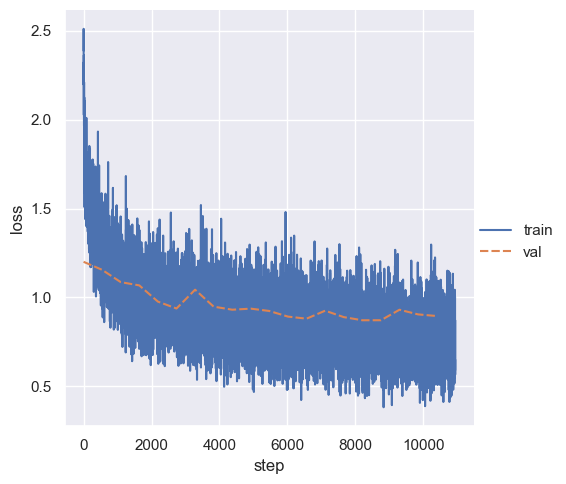

In [15]:
# plot for loss

plot_metrics(train_loss_log, val_loss_log, name="loss")

c:\Python310\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


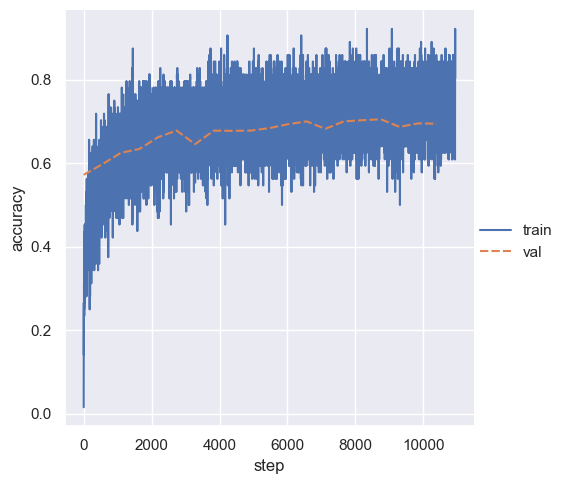

In [16]:
# plot for accuracy

plot_metrics(train_acc_log, val_acc_log, name="accuracy")

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [17]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4669017451772741, train acc: 0.47851103424372143
 val loss: 1.2513278705008486, val acc: 0.5660904255319149

Epoch 1
 train loss: 1.148462332471851, train acc: 0.5965534409395737
 val loss: 1.1480331722726214, val acc: 0.6013962765957447

Epoch 2
 train loss: 1.0503045976488856, train acc: 0.6340632346038191
 val loss: 1.1953364757781333, val acc: 0.5866356382978724

Epoch 3
 train loss: 0.9899041916378237, train acc: 0.6526508226691042
 val loss: 0.9895485040989328, val acc: 0.6577570922831272

Epoch 4
 train loss: 0.9542735307264589, train acc: 0.666863900542913
 val loss: 1.0247674444888502, val acc: 0.6433289007937655

Epoch 5
 train loss: 0.9232475703115655, train acc: 0.6797058632430473
 val loss: 0.9647437894597967, val acc: 0.6671320922831272

Epoch 6
 train loss: 0.9018657902694925, train acc: 0.6855983938987774
 val loss: 0.9362212789819596, val acc: 0.678036347602276

Epoch 7
 train loss: 0.8872793933591198, train acc: 0.6904381039591551
 val loss: 0.9

Посчитайте точность на тестовой выборке:

In [18]:
test_loss, test_acc = test(net, test_loader)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

test_loss: 0.8335262068138001
test_acc: 0.7154657643312102


**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [19]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader
)

Epoch 0
 train loss: 1.8587612253656336, train acc: 0.34674931444241314
 val loss: 1.638545586707744, val acc: 0.4319148936170213

Epoch 1
 train loss: 1.572611794175352, train acc: 0.44760789372149506
 val loss: 1.4885583106507647, val acc: 0.47814716316284017

Epoch 2
 train loss: 1.4449438107297015, train acc: 0.4922956386257569
 val loss: 1.4074445886814848, val acc: 0.5052969859001485

Epoch 3
 train loss: 1.3607519464039497, train acc: 0.5227172565416619
 val loss: 1.314440577588183, val acc: 0.5402703901554676

Epoch 4
 train loss: 1.2996346888420134, train acc: 0.5455120463040019
 val loss: 1.2576206706939859, val acc: 0.5646498227373082

Epoch 5
 train loss: 1.2456575869642184, train acc: 0.563560982073029
 val loss: 1.215270456101032, val acc: 0.5781028369639782

Epoch 6
 train loss: 1.2046850644038407, train acc: 0.5812997846324439
 val loss: 1.20262293561976, val acc: 0.5804964539852548

Epoch 7
 train loss: 1.160324628326967, train acc: 0.5960147885343492
 val loss: 1.1609

In [20]:
test_loss, test_acc = test(net, test_loader)
print(f"test_loss: {test_loss}")
print(f"test_acc: {test_acc}")

test_loss: 0.9373387500738642
test_acc: 0.6753582802547771


**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [21]:
from torch.optim.lr_scheduler import LinearLR, ReduceLROnPlateau, ExponentialLR

**LinearLR** - линейно изменяет lr от $\text{lr} \cdot \text{startFactor}$ до $\text{lr} \cdot \text{endFactor}$ (у меня почему-то тех не работает если использовать _ поэтому camelCase). 

In [22]:
# LinearLR

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = LinearLR(optimizer, start_factor=0.3, end_factor=1.0, total_iters=5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

# в этом случае lr будет следующим:
# iter = 0: lr=0.03
# iter = 1: lr=0.0475
# iter = 2: lr=0.065
# iter = 3: lr=0.0825
# iter >= 4: lr=0.1

Epoch 0
 train loss: 1.4527509572083162, train acc: 0.47857632541133455
 val loss: 1.3044631161588303, val acc: 0.5470079787234042

Epoch 1
 train loss: 1.154185533850459, train acc: 0.596157613031607
 val loss: 1.0757200248697971, val acc: 0.6254432624958931

Epoch 2
 train loss: 1.05124044233092, train acc: 0.631084323583181
 val loss: 1.0597234183169426, val acc: 0.6334219859001484

Epoch 3
 train loss: 1.0039726621054208, train acc: 0.6511613672132683
 val loss: 1.0320808425862738, val acc: 0.6359929079705097

Epoch 4
 train loss: 0.9655224394318827, train acc: 0.6642522526397565
 val loss: 1.013198712024283, val acc: 0.6501551420130628

Epoch 5
 train loss: 0.9442661806695858, train acc: 0.6703488182760026
 val loss: 1.0082325595490476, val acc: 0.6541445037151905

Epoch 6
 train loss: 0.9160896780503951, train acc: 0.683872257878619
 val loss: 0.9756747666825639, val acc: 0.6705008866939138

Epoch 7
 train loss: 0.8848722171739861, train acc: 0.6944331091980176
 val loss: 0.90121

In [23]:
test_loss, test_acc = test(net, test_loader)
print(f"LinearLR_test_loss: {test_loss}")
print(f"LinearLR_test_acc: {test_acc}")

LinearLR_test_loss: 0.8927030358344886
LinearLR_test_acc: 0.6969546178343949


**ReduceLROnPlateau** - начинает менять $\text{lr}$ (умножая его на $\text{factor}$) когда какая-то метрика (которую мы передаем в scheduler.step()) не улучшается уже $\text{patience}$ эпох 

In [24]:
# for ReduceLROnPlateau we need to pass metric to step


def train_pass_loss_to_scheduler_step(
    model, optimizer, n_epochs, train_loader, val_loader, scheduler=None
):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step(val_loss)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [25]:
# ReduceLROnPlateau

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, patience=3)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train_pass_loss_to_scheduler_step(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.5039880757358, train acc: 0.4616944698354662
 val loss: 1.333647041625165, val acc: 0.5315824468085106

Epoch 1
 train loss: 1.2258569576404648, train acc: 0.5703675895112088
 val loss: 1.1430329284769423, val acc: 0.6024822695458188

Epoch 2
 train loss: 1.1043143945812526, train acc: 0.6129945808616373
 val loss: 1.0836348444857495, val acc: 0.6161347518575953

Epoch 3
 train loss: 1.0294572862454263, train acc: 0.6409881823241602
 val loss: 1.0657543999083499, val acc: 0.6283909574468085

Epoch 4
 train loss: 0.9821944795753228, train acc: 0.6599348720292505
 val loss: 0.9640538796465448, val acc: 0.6630540781832756

Epoch 5
 train loss: 0.9434527606589267, train acc: 0.6736297010285763
 val loss: 0.9930694940242362, val acc: 0.6539671986661059

Epoch 6
 train loss: 0.9183184937105754, train acc: 0.680632182078562
 val loss: 1.0701609540492931, val acc: 0.6353058510638298

Epoch 7
 train loss: 0.8973695336137872, train acc: 0.6894342517939956
 val loss: 0.9291

In [26]:
test_loss, test_acc = test(net, test_loader)
print(f"ReduceLROnPlateau_test_loss: {test_loss}")
print(f"ReduceLROnPlateau_test_acc: {test_acc}")

ReduceLROnPlateau_test_loss: 0.8267446164112942
ReduceLROnPlateau_test_acc: 0.714171974522293


**ExponentialLR** - просто каждую эпоху домножает $\text{lr}$ на $\text{gamma}$

In [27]:
# ExponentialLR

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Epoch 0
 train loss: 1.4830601380991544, train acc: 0.4677665513655821
 val loss: 1.2218120501396503, val acc: 0.5712322696726373

Epoch 1
 train loss: 1.1204023266405247, train acc: 0.6052167668421046
 val loss: 1.0719853172910974, val acc: 0.6242907803109352

Epoch 2
 train loss: 0.9924268056749208, train acc: 0.6536261100437785
 val loss: 0.9911069509830881, val acc: 0.6530141845662543

Epoch 3
 train loss: 0.9320400587165596, train acc: 0.6771595063985375
 val loss: 0.9524536751686259, val acc: 0.6680851063829787

Epoch 4
 train loss: 0.8980536447800491, train acc: 0.6900137112607032
 val loss: 0.9253769146635177, val acc: 0.67788120584285

Epoch 5
 train loss: 0.8803207539771113, train acc: 0.6965550731261426
 val loss: 0.9189156471414769, val acc: 0.6796320922831272

Epoch 6
 train loss: 0.8698168947230309, train acc: 0.6991299948701039
 val loss: 0.9140233410165665, val acc: 0.6820921986661059

Epoch 7
 train loss: 0.8628671496180337, train acc: 0.7041737399109974
 val loss: 0.9

In [28]:
test_loss, test_acc = test(net, test_loader)
print(f"ExponentialLR_test_loss: {test_loss}")
print(f"ExponentialLR_test_acc: {test_acc}")

ExponentialLR_test_loss: 0.9078107016861059
ExponentialLR_test_acc: 0.6861066878980892


Как видим, какого-то прироста качества не наблюдается (лучшая accuracy получилось с помощью MultiStepLR - 0.71)

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

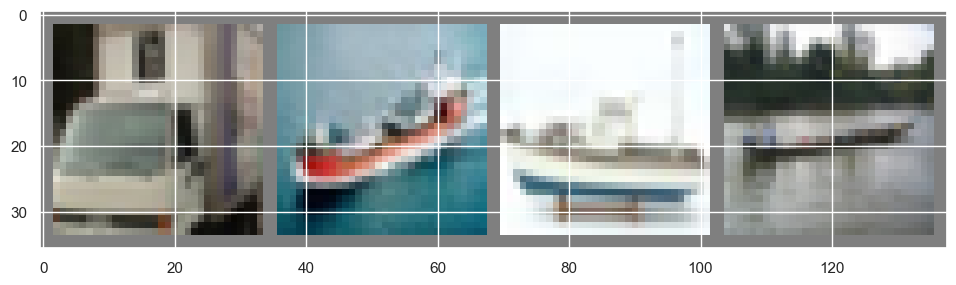

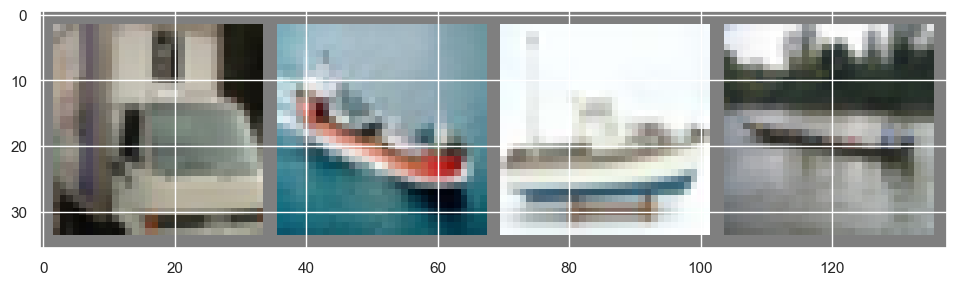

In [29]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [30]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4856096587843608, train acc: 0.46890506665928927
 val loss: 1.3248425164121262, val acc: 0.5249113476022761

Epoch 1
 train loss: 1.185835722159642, train acc: 0.5846459585526308
 val loss: 1.2008283206757078, val acc: 0.5832890071767441

Epoch 2
 train loss: 1.0554661531770906, train acc: 0.6307537869517938
 val loss: 1.0688822540831058, val acc: 0.6292996454746165

Epoch 3
 train loss: 1.00099875983634, train acc: 0.6524223034734917
 val loss: 0.9671208133088781, val acc: 0.664472517815042

Epoch 4
 train loss: 0.9646989680295452, train acc: 0.6652928310730776
 val loss: 0.9848864575649829, val acc: 0.6573138297872341

Epoch 5
 train loss: 0.931903642426897, train acc: 0.6755068230236688
 val loss: 0.9292059885694626, val acc: 0.6789007093044037

Epoch 6
 train loss: 0.9158317386777135, train acc: 0.6826602899396224
 val loss: 0.9433075483809126, val acc: 0.6751329787234043

Epoch 7
 tr

Посчитайте точность на тестовой выборке:

In [31]:
test_loss, test_acc = test(net, test_loader)
print(f"RandomHorizontalFlip_test_loss: {test_loss}")
print(f"RandomHorizontalFlip_test_acc: {test_acc}")

RandomHorizontalFlip_test_loss: 0.7987803837675957
RandomHorizontalFlip_test_acc: 0.7267117834394905


**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

**RandomGrayscale**: с вероятностью $p = 0.1$ (по умолчанию) делает изображение черно-белым. 

In [32]:
# RandomGrayscale

transform = transforms.Compose(
    [
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5122788480910347, train acc: 0.4630492622717207
 val loss: 1.291318898505353, val acc: 0.5361923759287976

Epoch 1
 train loss: 1.1959695712521918, train acc: 0.581830275559992
 val loss: 1.1095604224407927, val acc: 0.6107269503968827

Epoch 2
 train loss: 1.0700933826470942, train acc: 0.6300110995660534
 val loss: 1.0575665438428838, val acc: 0.6395168441407224

Epoch 3
 train loss: 1.0117352569996765, train acc: 0.6485129930419503
 val loss: 1.0378011934300686, val acc: 0.6401374114320634

Epoch 4
 train loss: 0.9643884922294338, train acc: 0.6646807261315298
 val loss: 1.0001219541468518, val acc: 0.6487588652904998

Epoch 5
 train loss: 0.930333708060507, train acc: 0.6774737202925045
 val loss: 0.9940127803924236, val acc: 0.6514849292471053

Epoch 6
 train loss: 0.9078423800917387, train acc: 0.6863206777537763
 val loss: 0.9263093476599835, val acc: 0.6769725178150421

Epoch 7
 t

In [33]:
test_loss, test_acc = test(net, test_loader)
print(f"RandomGrayscale_test_loss: {test_loss}")
print(f"RandomGrayscale_test_acc: {test_acc}")

RandomGrayscale_test_loss: 0.8107127463741667
RandomGrayscale_test_acc: 0.7192476114649682


**ColorJitter**: изменяет яркость, контрастность, насыщенность и hue (оттенок?) картинки. Каждый параметр изменяется в пределах (max(0, 1 - p), 1 + p), где p - переданное значение, или, если передано 2 значения, то изменяется в пределах (min, max), где min, max - два переданных значения.  

In [34]:
# ColorJitter

transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6622337148655921, train acc: 0.41175894490979487
 val loss: 1.4371036296195172, val acc: 0.49086879441078674

Epoch 1
 train loss: 1.32100908967651, train acc: 0.5406437712352062
 val loss: 1.2340073565219312, val acc: 0.5707003546522019

Epoch 2
 train loss: 1.1930112224174374, train acc: 0.5885919953613002
 val loss: 1.1606677486541424, val acc: 0.6044547872340426

Epoch 3
 train loss: 1.1270344150567622, train acc: 0.6131292439901851
 val loss: 1.1671743271198678, val acc: 0.6040115248649678

Epoch 4
 train loss: 1.0822087506707452, train acc: 0.6286440650767339
 val loss: 1.1733028911529704, val acc: 0.593594858240574

Epoch 5
 train loss: 1.0454780224036473, train acc: 0.6434406829926388
 val loss: 1.0508405530706364, val acc: 0.6365248228641267

Epoch 6
 train loss: 1.020773466478972, train acc: 0.6474928180304045
 val loss: 1.0620044766588415, val acc: 0.6287455674181593

Epoch 7
 

In [35]:
test_loss, test_acc = test(net, test_loader)
print(f"ColorJitter_test_loss: {test_loss}")
print(f"ColorJitter_test_acc: {test_acc}")

ColorJitter_test_loss: 0.8558108510485121
ColorJitter_test_acc: 0.7057125796178344


**RandomEqualize**: с вероятностью $p = 0.5$ (по умолчанию) выравнивает гистограмму распределения цветов изображения.

In [50]:
# RandomEqualize

transform = transforms.Compose(
    [
        transforms.RandomEqualize(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.5477132324326845, train acc: 0.4538676873857404
 val loss: 1.3110554936084342, val acc: 0.5413342199427016

Epoch 1
 train loss: 1.2318877113584628, train acc: 0.5716611713552388
 val loss: 1.1668079518257304, val acc: 0.5935726952045521

Epoch 2
 train loss: 1.138973781243103, train acc: 0.6064409767796832
 val loss: 1.1963511482198188, val acc: 0.5982269505237011

Epoch 3
 train loss: 1.0919869421169135, train acc: 0.6246327371004513
 val loss: 1.1742862503579323, val acc: 0.6000886525245424

Epoch 4
 train loss: 1.0465444958406132, train acc: 0.6409881823241602
 val loss: 1.0454238178882194, val acc: 0.6432402483960415

Epoch 5
 train loss: 1.015663217582912, train acc: 0.6515367915904936
 val loss: 1.066835997713373, val acc: 0.6320921986661059

Epoch 6
 train loss: 0.9974646821100489, train acc: 0.6603266192528622
 val loss: 1.0367561535632357, val acc: 0.650221631374765

Epoch 7
 tr

In [37]:
test_loss, test_acc = test(net, test_loader)
print(f"ColorJitter_test_loss: {test_loss}")
print(f"ColorJitter_test_acc: {test_acc}")

ColorJitter_test_loss: 0.8316847917380606
ColorJitter_test_acc: 0.7150676751592356


In [60]:
# и теперь попробуем обучить со всеми аугментациями:

transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        transforms.RandomEqualize(p=0.5),
        transforms.RandomGrayscale(p=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, val_loader, test_loader = get_cifar10_data(
    batch_size=64, transform_train=transform
)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(
    net, optimizer, 20, train_loader, val_loader, scheduler
)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6578778830481187, train acc: 0.41850434186471663
 val loss: 1.4311598529206946, val acc: 0.4963209220703612

Epoch 1
 train loss: 1.3539755842367518, train acc: 0.5371017237032135
 val loss: 1.3619740065107955, val acc: 0.5308510638297872

Epoch 2
 train loss: 1.2738714843607035, train acc: 0.5625
 val loss: 1.2713512139117464, val acc: 0.5679299646235527

Epoch 3
 train loss: 1.2270255883171528, train acc: 0.5791166101120944
 val loss: 1.3828361632976127, val acc: 0.5323359929500742

Epoch 4
 train loss: 1.184642778563107, train acc: 0.5950109363691898
 val loss: 1.2340226787201902, val acc: 0.5763519503968827

Epoch 5
 train loss: 1.1694918496081337, train acc: 0.6034294202297218
 val loss: 1.1910710991697109, val acc: 0.5845744680851064

Epoch 6
 train loss: 1.1437772767417391, train acc: 0.6061186014625228
 val loss: 1.2064147941609646, val acc: 0.5880097518575952

Epoch 7
 train loss

In [62]:
test_loss, test_acc = test(net, test_loader)
print(f"combined_transform_test_loss: {test_loss}")
print(f"combined_transform_test_acc: {test_acc}")

combined_transform_test_loss: 0.8944115604564642
combined_transform_test_acc: 0.6970541401273885


Как видим, в некоторых случаях получилось немного повысить accuracy (например, при использовании RandomGrayscale), но лучшее качество (при применении в одиночку) показал RandomHorizontalFlip. При применении всех аугментаций качество наоборот ухудшилось.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [38]:
import wandb

wandb.login(key="c95dea1ac5d5d044cd0ac07b932e8ed29ff89218", relogin=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\whoee/.netrc


True

In [56]:
# log to wandb funcs


def test_wandb(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        predictions = model(data)
        loss = cross_entropy(predictions, target)

        loss_log.append(loss.item())

        predicted_classes = torch.argmax(predictions, 1)
        acc = torch.sum(predicted_classes == target) / target.size(dim=0)

        acc_log.append(acc.item())

    log_dict = {
        "test/loss": np.mean(loss_log),
        "test/acc": np.mean(acc_log),
    }

    wandb.log(log_dict)

    return np.mean(loss_log), np.mean(acc_log)


def train_epoch_wandb(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        predictions = model(data)
        loss = cross_entropy(predictions, target)

        loss_log.append(loss.item())

        loss.backward()
        optimizer.step()

        predicted_classes = torch.argmax(predictions, 1)
        acc = torch.sum(predicted_classes == target) / target.size(dim=0)
        acc_log.append(acc.item())

        log_dict = {
            "train/loss": loss_log[-1],
            "train/acc": acc_log[-1],
        }

        wandb.log(log_dict)

    return loss_log, acc_log


def train_wandb(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    wandb.define_metric("val/loss", summary="min")

    wandb.define_metric("val/acc", summary="max")

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch_wandb(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        log_dict = {
            "val/loss": val_loss,
            "val/acc": val_acc,
        }

        wandb.log(log_dict)

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [57]:
# code from https://docs.wandb.ai/tutorials/pytorch


def model_pipeline():
    # tell wandb to get started
    with wandb.init(project="dl_shw2_ostashkov"):
        # make the model, data, and optimization problem
        model = BasicBlockNet().to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )

        train_loader, val_loader, test_loader = get_cifar10_data(
            batch_size=64, transform_train=transform
        )

        # and use them to train the model
        train_wandb(model, optimizer, 20, train_loader, val_loader)

        # and test its final performance
        test_wandb(model, test_loader)

    return model

In [58]:
model_pipeline()

Files already downloaded and verified
Files already downloaded and verified


test/acc,▁
test/loss,▁
train/acc,▁▄▂▄▅▅▄▇▆▅▄▄▅▆▅▃▅▅▆▆▇▆▆▄▆▅▆▅▆▆▇▆▇▆▆▇▇█▆▇
train/loss,█▅▆▅▄▄▄▂▂▂▄▅▃▁▄▄▃▃▃▃▂▂▃▂▂▃▁▃▁▂▁▂▂▂▂▁▁▁▂▁
val/acc,▁▄▅▅▆▅▆▇▆▇▇▇██▇█▇███
val/loss,█▅▅▄▃▃▂▂▃▂▂▂▁▁▂▁▂▁▁▂
test/acc,0.69019
test/loss,0.91489
train/acc,0.625
train/loss,1.14688


BasicBlockNet(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (block2): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

In [59]:
wandb.finish(0)

Ссылка на ран: https://wandb.ai/max23-ost/dl_shw2_ostashkov/runs/j99hyiup?workspace=user-max23-ost